# Procesamiento de la base de datos Skin_NonSkin


# Unidad 3 - Evaluación aprendizaje

### Presentado por: 
### Oscar Javier Camargo Martínez
### Camilo Castro Duarte
### Diego Alejandro Becerra


A partir de los datos que se entregan en el enlace https://archive.ics.uci.edu/ml/datasets/skin+segmentation (archivo Skin_NonSkin.txt), realizar las etapas de preparación de los datos y modelado (usando un modelo de regresión logística). Luego realizar el test y aplicar la evaluación del modelo. Escribir el programa en lenguaje python desde google colab.

La evaluación debe hacerse a partir de dos de los esquemas de validación presentados en la sección 11.5 de la lectura del momento de experiencia: “N-folds validation” con N=10 y “random subsampling” utilizando una partición 70/30, es decir, 70% de los datos para el train y el 30% restante para el test, con 10 repeticiones.La evaluación debe incluir


## Dataset
El conjunto de datos de la piel se recopila mediante un muestreo aleatorio de valores B, G, R de imágenes faciales de varios grupos de edad (jóvenes, medianos y mayores), grupos raciales (blanco, negro y asiático) y géneros obtenidos de la base de datos FERET y la base de datos PAL. . El tamaño total de la muestra de aprendizaje es 245057; de las cuales 50859 son muestras de piel y 194198 son muestras que no son de piel.

Este conjunto de datos tiene la dimensión 245057 * 4, donde las tres primeras columnas son valores B, G, R (características x1, x2 y x3) y la cuarta columna es de las etiquetas de clase (variable de decisión y).

In [ ]:
# Carga de librerías y lectura del archivo que contiene los datos

import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix


#data = pd.read_csv(r'C:\Users\Camilo Castro\Desktop\Base python\Skin_NonSkin.txt', delimiter='\t')
data = pd.read_csv(r'https://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt', delimiter='\t')


# Se etiquetan las columnas para poder interpretar más fácilmente los datos.
# Cada fila es un ejemplo, cada columna un atributo.
# La columna llamada Piel es el atributo a predecir
data.columns = ['B', 'G', 'R', 'Piel']
data.head()

,B,G,R,Piel
0,73,84,122,1
1,72,83,121,1
2,70,81,119,1
3,70,81,119,1
4,69,80,118,1


In [ ]:
#Cuál es el número de registros?
#Cuál es el número de atributos?

shape = data.shape
shape

(245056, 4)

In [ ]:
#Cual es el tipo de los atributos?
data.dtypes

B       int64
G       int64
R       int64
Piel    int64
dtype: object

In [ ]:
#Medida de centralidad y desviación para atributos numéricos:
data.describe()

,B,G,R,Piel
count,245056.000000,245056.000000,245056.000000,245056.000000
mean,125.065654,132.507521,123.177151,1.792464
std,62.255694,59.941243,72.562313,0.405544
min,0.000000,0.000000,0.000000,1.000000
25%,68.000000,87.000000,70.000000,2.000000
50%,139.000000,153.000000,128.000000,2.000000
75%,176.000000,177.000000,164.000000,2.000000
max,255.000000,255.000000,255.000000,2.000000


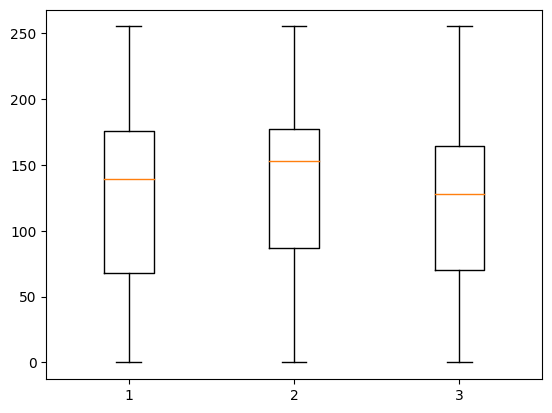

In [ ]:
# Diagrama de cajas y bigotes para atributos numéricos
# Permite identificar la existencia de datos atípicos

plt.boxplot((data['B'],data['G'],data['R']))
plt.show()

In [ ]:
data_numericas = data.select_dtypes(include = ['int64'])

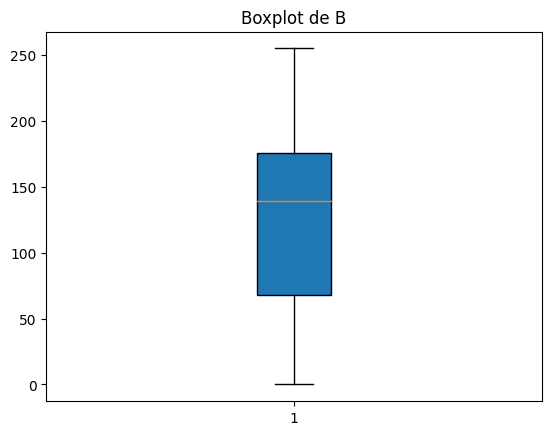

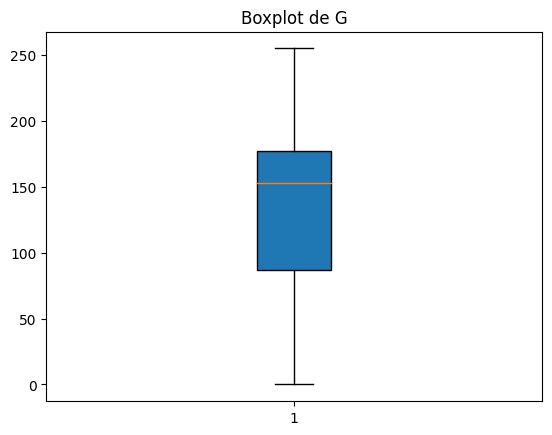

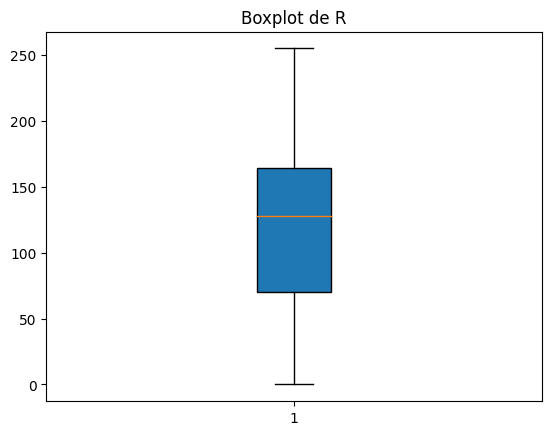

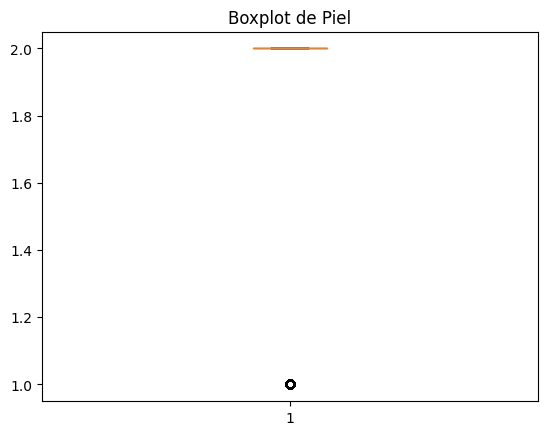

In [ ]:
for i in (data_numericas.columns):
    plt.boxplot(data_numericas[i], patch_artist=True)
    plt.title("Boxplot de " + i)
    plt.show()

In [ ]:
#Medida de centralidad para atributos categóricos:
data.mode()

,B,G,R,Piel
0,178,178,0,2


In [ ]:
# Correlación entre los atributos de entrada numéricos
# Permite detectar si hay atributos redundantes (correlación mayor a 0.85 o menor a -0.85)
data.corr()

,B,G,R,Piel
B,1.000000,0.855250,0.496377,0.092024
G,0.855250,1.000000,0.660099,-0.120335
R,0.496377,0.660099,1.000000,-0.569963
Piel,0.092024,-0.120335,-0.569963,1.000000


<Axes: >

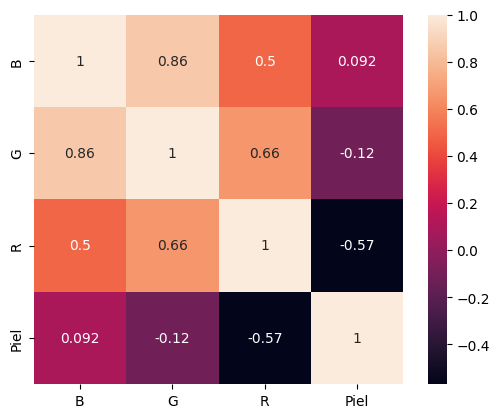

In [ ]:
sns.heatmap(data.corr(), square=True, annot=True)

In [ ]:
# Cual es el máximo de datos faltantes en un mismo registro?, o mas bien, cuantos atributos tienen datos faltantes
# Si hay registros a los que les faltan muchos valores, es mejor eliminarlos.
max(data.isnull().sum(axis=1))

0

In [ ]:
#Cuantos datos faltantes hay por cada atributo?
data.isnull().sum()

B       0
G       0
R       0
Piel    0
dtype: int64

In [ ]:
#Cuantos registros hay por cada clase? es decir, por cada valor del atributo de salida?

print(data['Piel'].value_counts())

2    194198
1     50858
Name: Piel, dtype: int64


## Etapa 2: Preparación de los datos
De acuerdo a lo observado en la etapa 1, se define una secuencia de actividades que modifican los datos para eliminar las situaciones que puedan ser causa de fallo o deficiencia en el proceso de aprendizaje. En este caso se van a realizar las siguientes actividades:









1.   Eliminar del modelo el atributo **G** dado que tiene una correlación bastante alta con **B** y está algo correlacionado con **R**.

In [ ]:
data = data.drop(['G'], axis = 1)
data.head(5)

,B,R,Piel
0,73,122,1
1,72,121,1
2,70,119,1
3,70,119,1
4,69,118,1


2. Balancear las clases eliminando registros de la clase mayoritaria.

In [ ]:
# Se hace balanceo de clases eliminando ejemplos de la clase mayoritaria
g = data.groupby('Piel')
dataBal = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
dataBal

B    R  Piel
Piel                      
1    0       84  132     1
     1       61  190     1
     2       96  220     1
     3      107  189     1
     4      126  218     1
...         ...  ...   ...
2    50853   54   22     2
     50854  144   87     2
     50855   55   26     2
     50856   72   28     2
     50857  143  103     2

[101716 rows x 3 columns]

In [ ]:
# Se verifica que haya quedado el mismo número de registros por cada clase
print(dataBal['Piel'].value_counts())

1    50858
2    50858
Name: Piel, dtype: int64


In [ ]:
#Cual es el tipo de los atributos?
dataBal.dtypes

B       int64
R       int64
Piel    int64
dtype: object

## Etapa 3: Modelado
En esta etapa se van a utilizar los datos para realizar aprendizaje del atributo C a partir de los valores de los demás atributos. Las actividades a realizar son:
1.   Dividir el conjunto de datos en conjuntos de entrenamiento y test.
2.   Realizar el entrenamiento del modelo de regresión logística utilizando para ello el conjunto de entrenamiento.
3.   Aplicar el modelo construido a los datos del conjunto de test.
4.   Cálculo de una métrica de desempeño para evaluar la calidad del modelo en sus prediciones sobre el conjunto de test.

In [ ]:
# Dividir el conjunto de datos en conjuntos de entrenamiento y test

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(dataBal.drop('Piel', axis=1), dataBal.Piel, test_size=0.30)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(71201, 2) (71201,)
(30515, 2) (30515,)


In [ ]:
# Entrenamiento del modelo de clasificación por regresión logística
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logisticRegr = LogisticRegression(solver="lbfgs", max_iter=500, tol=0.01)
logisticRegr.fit(X_train, y_train)


LogisticRegression(max_iter=500, tol=0.01)

In [ ]:
# Aplicación del modelo construido a los datos de test
predictions = logisticRegr.predict(X_test)
predictions

array([2, 1, 1, ..., 2, 1, 2])

In [ ]:
# Cálculo del accuracy para evaluar el desempeño del modelo sobre los datos de test
from sklearn.metrics import accuracy_score

accuracy_score(y_test, predictions)

0.9511060134360151

In [ ]:
#Evaluamos el modelo utilizando los conjuntos de prueba y calculamos las medidas de rendimiento solicitadas:
y_pred = logisticRegr.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[14908   305]
 [ 1187 14115]]
              precision    recall  f1-score   support

           1       0.93      0.98      0.95     15213
           2       0.98      0.92      0.95     15302

    accuracy                           0.95     30515
   macro avg       0.95      0.95      0.95     30515
weighted avg       0.95      0.95      0.95     30515



              precision    recall  f1-score   support

           1     0.9263    0.9800    0.9523     15213
           2     0.9788    0.9224    0.9498     15302

    accuracy                         0.9511     30515
   macro avg     0.9525    0.9512    0.9511     30515
weighted avg     0.9526    0.9511    0.9511     30515



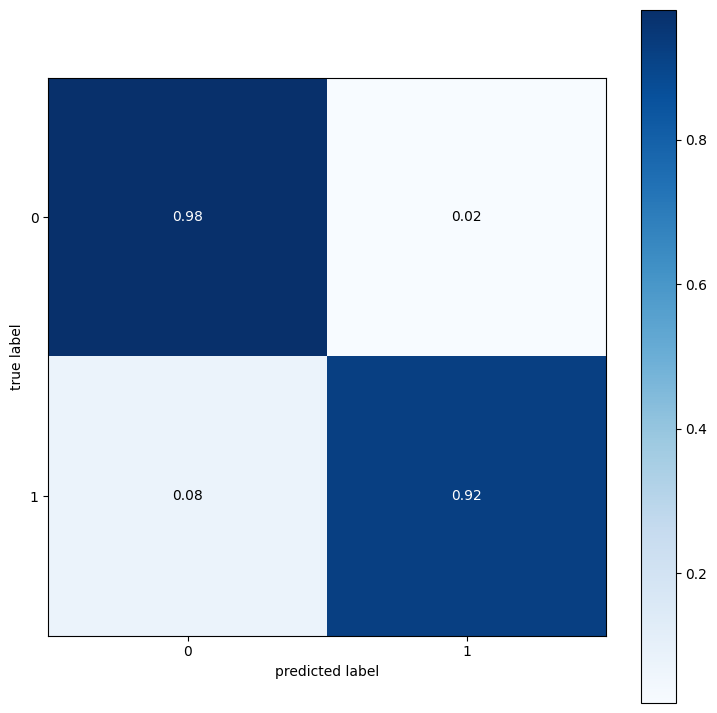

In [ ]:
#Generación de la matriz y metricas

matc=confusion_matrix(y_test, predictions)

print(metrics.classification_report(y_test,predictions, digits = 4))

plot_confusion_matrix(conf_mat=matc, figsize=(9,9), colorbar=True, show_absolute=False, show_normed=True)
#plot_confusion_matrix(conf_mat=matc, figsize=(9,9), show_absolute=False, show_normed=True, class_names=names)
plt.show()

In [ ]:
#Exactitud
exactitud = accuracy_score(y_test, predictions)
print(exactitud)

0.9511060134360151


In [ ]:
#Precision
precision = precision_score(y_test, predictions)
print(precision)

0.9262503883193538


In [ ]:
#Sensibilidad
sensibilidad = recall_score(y_test, predictions)
print(sensibilidad)

0.9799513573917045


In [ ]:
#F1
puntaje = f1_score(y_test, predictions)
print(puntaje)

0.9523444487032069


# La evaluación a partir de "N-folds validation"

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Definir los datos de entrada y salida
X = dataBal.drop('Piel', axis=1)
y = dataBal.Piel

# Inicializar las métricas
acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []
conf_matrices = []

# Definir el modelo de regresión logística
lr = LogisticRegression()

# Definir el objeto de validación cruzada
n_folds = 10
skf = StratifiedKFold(n_splits=n_folds)

# Iterar sobre los folds
for train_index, test_index in skf.split(X, y):
    # Separar los datos en train y test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenar el modelo
    lr.fit(X_train, y_train)
    
    # Evaluar el modelo en el conjunto de test
    y_pred = lr.predict(X_test)
    acc_scores.append(accuracy_score(y_test, y_pred))
    prec_scores.append(precision_score(y_test, y_pred))
    rec_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    conf_matrices.append(confusion_matrix(y_test, y_pred))
    
# Imprimir las métricas promedio de todos los folds
print(f"Accuracy: {np.mean(acc_scores)}")
print(f"Precision: {np.mean(prec_scores)}")
print(f"Recall: {np.mean(rec_scores)}")
print(f"F1-score: {np.mean(f1_scores)}")

# Imprimir la matriz de confusión promedio de todos los folds
mean_conf_matrix = np.mean(conf_matrices, axis=0)
print(f"\nMatriz de Confusión Promedio:\n{mean_conf_matrix}")


Accuracy: 0.9512662917512038
Precision: 0.9262977781509152
Recall: 0.980573293723569
F1-score: 0.9526560625676627

Matriz de Confusión Promedio:
[[4987.    98.8]
 [ 396.9 4688.9]]


# Validación de Submuestra aleatoria con 10 repeticiones y una partición de 70/30:

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Definir los parámetros de validación cruzada
test_size = 0.3
n_splits = 10
random_state = 42

# Crear el objeto validación cruzada
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

# Crear listas vacías para almacenar las métricas de evaluación
acc_scores = []
cm_list = []
clf_reports = []

# Realizar la validación cruzada
for train_index, test_index in cv.split(dataBal):
    
    # Dividir los datos en entrenamiento y prueba
    X_train, X_test = dataBal.iloc[train_index, :-1], dataBal.iloc[test_index, :-1]
    y_train, y_test = dataBal.iloc[train_index, -1], dataBal.iloc[test_index, -1]

    # Crear un modelo de regresión logística y entrenarlo
    clf = LogisticRegression(random_state=random_state)
    clf.fit(X_train, y_train)

    # Predecir las etiquetas de la prueba
    y_pred = clf.predict(X_test)

    # Calcular la precisión y guardarla en la lista de precisión
    acc = accuracy_score(y_test, y_pred)
    acc_scores.append(acc)

    # Calcular la matriz de confusión y guardarla en la lista de matrices de confusión
    cm = confusion_matrix(y_test, y_pred)
    cm_list.append(cm)

    # Calcular el informe de clasificación y guardarlo en la lista de informes de clasificación
    clf_report = classification_report(y_test, y_pred)
    clf_reports.append(clf_report)

# Calcular las métricas promedio de evaluación
avg_acc = sum(acc_scores) / len(acc_scores)
avg_cm = sum(cm_list) / len(cm_list)
avg_clf_report = "\n\n".join(clf_reports)

# Imprimir las métricas promedio de evaluación
print("Average Accuracy:", avg_acc)
print("Average Confusion Matrix:\n", avg_cm)
print("Average Classification Report:\n", avg_clf_report)


Average Accuracy: 0.9509650991315747
Average Confusion Matrix:
 [[14984.9   312.1]
 [ 1184.2 14033.8]]
Average Classification Report:
               precision    recall  f1-score   support

           1       0.93      0.98      0.95     15265
           2       0.98      0.92      0.95     15250

    accuracy                           0.95     30515
   macro avg       0.95      0.95      0.95     30515
weighted avg       0.95      0.95      0.95     30515


              precision    recall  f1-score   support

           1       0.92      0.99      0.95     15205
           2       0.99      0.92      0.95     15310

    accuracy                           0.95     30515
   macro avg       0.95      0.95      0.95     30515
weighted avg       0.95      0.95      0.95     30515


              precision    recall  f1-score   support

           1       0.93      0.98      0.95     15312
           2       0.98      0.92      0.95     15203

    accuracy                           0.95  

# Analisis de resultados

Primero, haremos un pequeño resumen de los resultados obtenidos en las métricas al momento de aplicar una regresión logística:

- **accuracy_score:** 0.9511060134360151
- **precision_score:** 0.9262503883193538
- **recall_score:** 0.9799513573917045
- **f1_score:** 0.9523444487032069

Respecto a lo anterior podemos conjeturar que realmente el modelo tiene resultados bastante aceptables dado que presente unas métricas por encima del **92%**, incluso nos permite llegar a tener **recall** de **98%**.

Por otra parte, al aplicar **N-Folds Validation** con una sola repetición encontramos lo siguiente:

- **accuracy_score:** 0.9512662917512038
- **precision_score:** 0.9262977781509152
- **recall_score:** 0.980573293723569
- **f1_score:** 0.9526560625676627

No encontramos diferencias significativas entre la regresión logística y N-Folds Validation; sin embargo, "hilando fino" podríamos decir que N-Folds Validation mejora un poco la regresión logística.

Adicionalmente, al momento de replicar la validación con una submuestra aleatoria de 10 repeticiones y una partición de 70/30, obtenemos que las métricas no muestran una diferencia significativa de la conclusión mostrada anteriormente. No obstante, es una conclusión que solo aplicaría, al menos en principio, para este ejercicio y esta base de datos.